In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

# temporary files: /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# read data and check for null
dt = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

print('Train data')
dt.head()
dt.describe()
print(dt.isnull().any())
print('Test data')
print(test.isnull().any())

Train data
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool
Test data
PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool


In [3]:
# code category into binary var
gender = {'male': 0, 'female': 1}
dt['Sex_bin'] = pd.DataFrame([gender[g] for g in dt.Sex])
test['Sex_bin'] = pd.DataFrame([gender[g] for g in test.Sex])

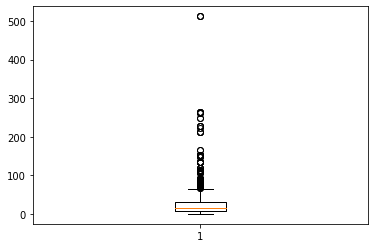

512.3292
Lower whisker:  0.0
Upper whisker:  65.0


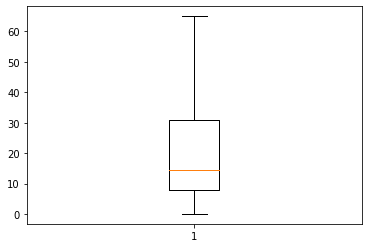

In [4]:
### handling fare outliers
# find lower and upper whisker of a boxplot (representing min and max of middle 50% interval)
plt.boxplot(dt.Fare)
plt.show()

# q1 = train.Fare.quantile(0.25)
# q3 = train.Fare.quantile(0.75)
# low_whisker = train.Fare[train.Fare >= q1 - 1.5*(q3-q1)].min()
# upp_whisker = train.Fare[train.Fare <= q3 + 1.5*(q3-q1)].max()

def remove_fare_outliers(df):
    fare_boxplot = plt.boxplot(df.Fare)
    plt.close()

    [low_whisker, upp_whisker] = [item.get_ydata()[1] for item in fare_boxplot['whiskers']]
    print("Lower whisker: ", low_whisker)
    print("Upper whisker: ", upp_whisker)

    # create new column with replaced values
    df['Fare_wt_outliers'] = df['Fare']
    df.loc[df.Fare_wt_outliers < low_whisker, 'Fare_wt_outliers'] = low_whisker
    df.loc[df.Fare_wt_outliers > upp_whisker, 'Fare_wt_outliers'] = upp_whisker
    
    return df

print(dt.Fare.max())
dt = remove_fare_outliers(dt)
plt.boxplot(dt.Fare_wt_outliers)
plt.show()


In [5]:
# there are missing values in test set
test[test.Fare.isnull()]

# fill missing values with the median within Pclass = 3
# filling done separately on test set (we do not want to influence test set with training and vice versa)
test.loc[test.Fare.isnull(), 'Fare'] = test.loc[test.Pclass == 3, 'Fare'].median()

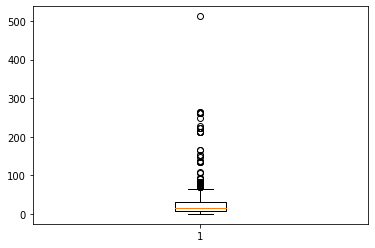

Lower whisker:  0.0
Upper whisker:  65.0


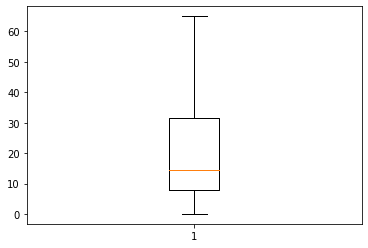

In [6]:
### test set
plt.boxplot(test.Fare)
plt.show()

test = remove_fare_outliers(test)
plt.boxplot(test.Fare_wt_outliers)
plt.show()

In [7]:
# split dt into train and validation sets
train = dt.sample(frac=0.8, random_state=0)
validation = dt.drop(train.index)

len(train) + len(validation) == len(dt)

True

In [8]:
# store accuracy results for each model
accuracy_results = pd.DataFrame(columns=['model', 'features', 'train_acc', 'validation_acc', 'test_acc'])

In [9]:
# pipeline functions
def create_and_fit_decision_tree(data, X, Y, criterion, show_plot=True):
    model = tree.DecisionTreeClassifier(criterion=criterion)
    model.fit(data[X],data[Y])   
    if show_plot == True:
        plt.figure(figsize=(len(X)*5,len(X)*5))
        tree.plot_tree(model, feature_names=X)
        plt.show()
    return model
   
def calculate_prediction(model, data, features):
    return model.predict(data[features])

def calculate_accuracy(set_name, y_true, y_pred):
    vol = accuracy_score(y_true, y_pred, normalize=False)
    frac = accuracy_score(y_true, y_pred, normalize=True)
    print(set_name, ": ", vol, " correctly classified samples - ", round(100*frac,2), "%")
    return frac
    
def create_submission(model, test_data, X):
    prediction = pd.Series(model.predict(test_data[X]))
    subm = pd.concat([test.PassengerId, prediction], axis=1)
    subm.columns = ['PassengerId', 'Survived']
    return subm

def store_accuracy_results(accuracy_results, model_name, X, train_acc, validation_acc, test_acc):
    return accuracy_results.append({'model': model_name,
                                    'features': X,
                                    'train_acc': train_acc, 
                                    'validation_acc': validation_acc, 
                                    'test_acc': test_acc}, ignore_index = True)

In [10]:
# pipeline
def run_dt(train, validation, X, Y, criterion, show_plot=True):
    # create and train the tree
    model = create_and_fit_decision_tree(train, X, Y, criterion, show_plot)

    # create prediction on train and validation sets
    train_predict = calculate_prediction(model, train, X)
    validation_predict = calculate_prediction(model, validation, X)

    # print accuracy of the prediction
    train_acc = calculate_accuracy("Train", train[Y], train_predict)
    validation_acc = calculate_accuracy("Validation", validation[Y], validation_predict)
    
    return model, train_acc, validation_acc

# Decision Tree 1

Features: Sex_bin

Criterion: Gini impurity

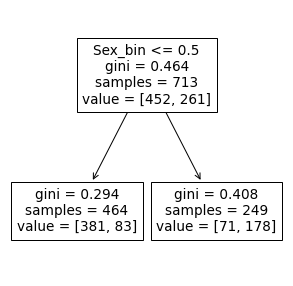

Train :  559  correctly classified samples -  78.4 %
Validation :  142  correctly classified samples -  79.78 %


In [11]:
X1 = ['Sex_bin']
Y = 'Survived'
criterion = "gini"

dtree1, train_acc1, validation_acc1 = run_dt(train, validation, X1, Y, criterion)
# value array tells how many samples fall into each to-be-predicted category (value = [549, 342] means that
# there are 549 0s and 342 1s)
# gini index drops with the division of the node -> good
subm1 = create_submission(dtree1, test, X1)
subm1.to_csv('submission1.csv', index=False)
# test submission resulted in 0.76555

# store accuracy
accuracy_results = store_accuracy_results(accuracy_results, 'dtree1', X1, train_acc1, validation_acc1, test_acc=0.76555)

## Gini index

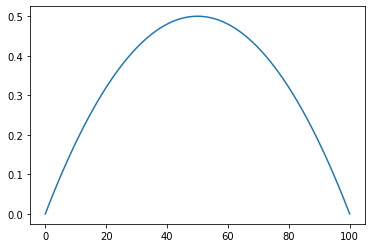

In [12]:
###  Gini index - visualization on dummy data
n = 100
# create 101 classes of different proportions of 0s and 1s
classes = pd.DataFrame(data=np.zeros(shape=(n,n+1)),columns = ['c'+str(k) for k in range(n+1)])
for k in range(1,n+1):
    classes['c'+str(k)].iloc[0:k] = 1
# print(classes)
cnt = classes.sum()

# calculate prob of 0 and 1 for each node
probs_0 = [(n-c)/n for c in cnt]
probs_1 = [c/n for c in cnt]

# Gini formula for node (class) with given no of 0s and 1s = 1-(P(0)^2+P(1)^2), 
# where P - probability function (based on frequency)
# In general, Gini formula for class c: G(c)= 1-sum{k in 1..n} P(k)^2, where n is number of different elements in class c

gini_index = [1 - (probs_0[k]**2 + probs_1[k]**2) for k in range(n+1)]
plt.plot(gini_index)

# The closer Gini index is to 0, the more purity we have in the node of the tree

# Decision Tree 2

Features: Sex_bin

Criterion: entropy

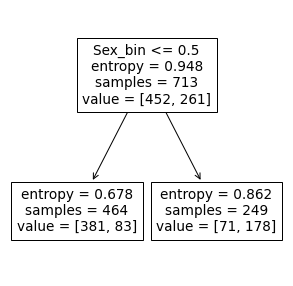

Train :  559  correctly classified samples -  78.4 %
Validation :  142  correctly classified samples -  79.78 %
True


In [13]:
X2 = ['Sex_bin']
Y = 'Survived'
criterion = "entropy"

dtree2, train_acc2, validation_acc2 = run_dt(train, validation, X2, Y, criterion)
subm2 = create_submission(dtree2, test, X2)
print(all(subm2 == subm1))
# identical submission to subm1

accuracy_results = store_accuracy_results(accuracy_results, 'dtree2', X2, train_acc2, validation_acc2, test_acc=0.76555)

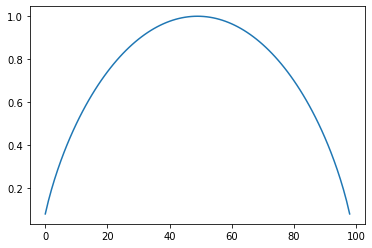

In [14]:
### entropy - visualization on dummy data
from math import log2

entropy = [-(probs_0[k]*log2(probs_0[k]) + probs_1[k]*log2(probs_1[k])) for k in range(1,n)] # for k=0 and k=n+1 log doesnt exist
plt.plot(entropy)

# Decision Tree 3

Features: Sex_bin, Pclass

Criterion: gini

In [15]:
# contingency table (crosstab)
sex_vs_pclass = pd.pivot_table(train, values='PassengerId', index='Sex', columns='Pclass', aggfunc='count')
sex_vs_pclass

Pclass,1,2,3
Sex,,,
female,74,59,116
male,96,83,285


In [16]:
import scipy.stats as stats

# chi-squared test statistic, sample size, and minimum of rows and columns
chi2, pval, _, _ = stats.chi2_contingency(sex_vs_pclass, correction=False)
# H0: there is no dependence between sex and pclass
# p = probability that the dependence is caused by random noise; if p<0.05, we can deny H0
print("p-value: ", pval)

# chi2 is affected by sample size and no of rows and columns 
# Cramer's V attempts to adjust for these
n = np.sum(sex_vs_pclass).sum() 
minDim = min(sex_vs_pclass.shape)-1 # no of degrees of freedom

# calculate Cramer's V - effect size measurement that tells how strong the relationship is
V = np.sqrt((chi2/n) / minDim)
print("Cramer's V: ", V)
# 0 - no correlation, 1 - strong correlation

# interpretation of Cramer's V depends on no of degrees of freedom
# there are many rules of thumb but in general for df=1 V=0.14 is pretty small

p-value:  0.0006667944244384897
Cramer's V:  0.1432250141596954


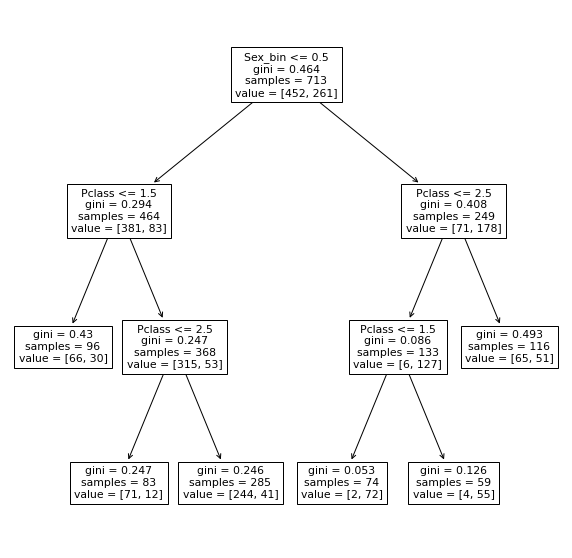

Train :  573  correctly classified samples -  80.36 %
Validation :  128  correctly classified samples -  71.91 %


In [17]:
X3 = ['Sex_bin', 'Pclass']
Y = 'Survived'
criterion = "gini"

dtree3, train_acc3, validation_acc3 = run_dt(train, validation, X3, Y, criterion)
subm3 = create_submission(dtree3, test, X3)
subm3.to_csv('submission3.csv', index=False)
# train fits better, validation worse - suggest overfitting
# test submission 0.77511 (only slightly better

accuracy_results = store_accuracy_results(accuracy_results, 'dtree3', X3, train_acc3, validation_acc3, test_acc=0.77511)

# Decision Tree 4

Features: Sex_bin, Pclass, Fare

Criterion: gini

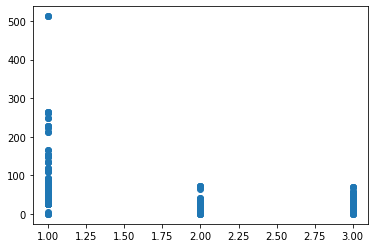

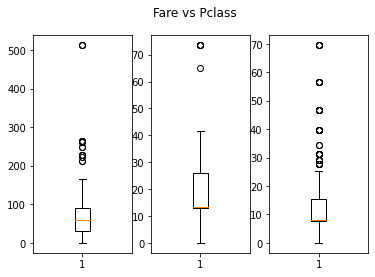

In [18]:
# plot Pclass vs Fare amount to see if there is any correspondence
plt.scatter(train.Pclass, train.Fare)
plt.show()

# use boxplot to have more insight
# train[['Pclass','Fare']].boxplot(column='Fare',by='Pclass')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Fare vs Pclass')
ax1.boxplot(x=train.Fare[train.Pclass==1])
ax2.boxplot(x=train.Fare[train.Pclass==2])
ax3.boxplot(x=train.Fare[train.Pclass==3])
plt.show()
# Fare clearly depends on the Pclass, there are only few outliers

In [19]:
# calculate mean fare value by class
mean_fare_by_pclass = test.groupby(by='Pclass').mean().Fare.to_dict()
# replace null values
test.Fare.fillna(test.Pclass.map(mean_fare_by_pclass), inplace=True)
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Fare_wt_outliers


In [20]:
# test if adding correlated information causes overfitting
X4 = ['Sex_bin', 'Pclass', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree4, train_acc4, validation_acc4 = run_dt(train, validation, X4, Y, criterion, show_plot=False)
subm4 = create_submission(dtree4, test, X4)
subm4.to_csv('submission4.csv', index=False)

# train and validation results a lot better (unexpected for validation), test result - worse (quite expected)
accuracy_results = store_accuracy_results(accuracy_results, 'dtree4', X4, train_acc4, validation_acc4, test_acc=0.76076)

Train :  648  correctly classified samples -  90.88 %
Validation :  141  correctly classified samples -  79.21 %


# Decision Tree 5

Features: Sex_bin, Fare

Criterion: gini

In [21]:
X5 = ['Sex_bin', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree5, train_acc5, validation_acc5 = run_dt(train, validation, X5, Y, criterion, show_plot=False)
subm5 = create_submission(dtree5, test, X5)
subm5.to_csv('submission5.csv', index=False)


# train and validation results similar to dtree4, test result again worse
accuracy_results = store_accuracy_results(accuracy_results, 'dtree5', X5, train_acc5, validation_acc5, test_acc=0.75837)


Train :  647  correctly classified samples -  90.74 %
Validation :  142  correctly classified samples -  79.78 %


In [22]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare]",0.908836,0.792135,0.76076
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.75837


# Decision Tree 6

Features: Sex_bin, Pclass, Fare w/t outliers

Criterion: gini

In [23]:
X6 = ['Sex_bin', 'Pclass', 'Fare_wt_outliers']
Y = 'Survived'
criterion = "gini"

dtree6, train_acc6, validation_acc6 = run_dt(train, validation, X6, Y, criterion, show_plot=False)
subm6 = create_submission(dtree6, test, X6)
subm6.to_csv('submission6.csv', index=False)

# accuracy_results = store_accuracy_results(accuracy_results, 'dtree6', X6, train_acc6, validation_acc6, test_acc=[])

Train :  639  correctly classified samples -  89.62 %
Validation :  142  correctly classified samples -  79.78 %


# Cross-validation

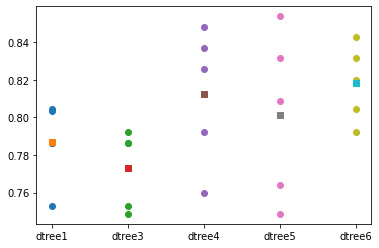

Average cv_score:
dtree1    0.786737
dtree3    0.773316
dtree4    0.812629
dtree5    0.801406
dtree6    0.818197
dtype: float64


In [24]:
from sklearn.model_selection import cross_val_score
cv_score = {}
cv_no = 5
cv_score['dtree1'] = cross_val_score(dtree1, dt[X1], dt[Y], cv=cv_no)
cv_score['dtree3'] = cross_val_score(dtree3, dt[X3], dt[Y], cv=cv_no)
cv_score['dtree4'] = cross_val_score(dtree4, dt[X4], dt[Y], cv=cv_no)
cv_score['dtree5'] = cross_val_score(dtree5, dt[X5], dt[Y], cv=cv_no)
cv_score['dtree6'] = cross_val_score(dtree6, dt[X6], dt[Y], cv=cv_no)

# plt.scatter(pd.DataFrame(cv_score))
cv_score = pd.DataFrame(cv_score)
for cv in cv_score.columns:
    plt.scatter([cv]*cv_no, cv_score[cv])
    plt.scatter(cv, cv_score[cv].mean(), marker='s')
plt.show()

print('Average cv_score:')
print(cv_score.mean())

In [25]:
accuracy_results
# highest accuracy for dtree4 (with both Pclass and Fare)

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare]",0.908836,0.792135,0.76076
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.75837


In [26]:
train.Age

495     NaN
648     NaN
278     7.0
31      NaN
255    29.0
       ... 
25     38.0
110    47.0
149    42.0
152    55.5
528    39.0
Name: Age, Length: 713, dtype: float64